<a href="https://colab.research.google.com/github/avfka/itmo-ml-labs-2025/blob/main/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений и композиции

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pprint import pprint

В этой лабораторной вам предстоит поработать с классификацией. Задача классификации в машинном обучении - это один из основных типов задач, где модель обучается предсказывать категориальную метку или класс для заданного входного наблюдения на основе обучающего набора данных, содержащего пары "входные данные - целевая метка".

Можно выделить несколько видов классификации:

* Binary - целевой признак имеет метку 0/1;
* Multiclass - целевой признак имеет метку из ограниченного множества (0, 1, 2, 3...);
* Multilabel - целевой признак может иметь несколько меток одновременно.

Классификацию можно решать как задачу регрессии (задача предсказания значения из непрерывного множества), затем выбирая порог - всем значениям меньше порога будет присвоена метка 0, всем значениям выше - метка 1.

# Деревья решений

Решающие деревья - алгоритм машинного обучения, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным.

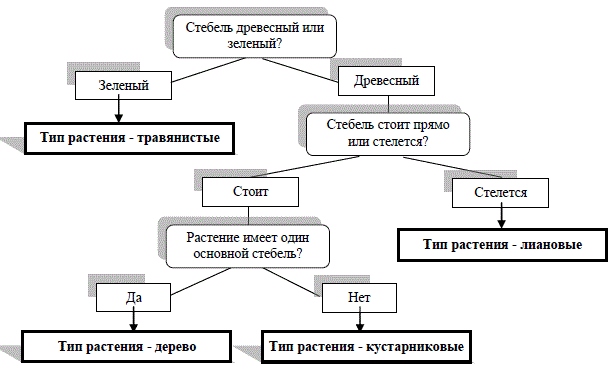

По сути, мы рекурсивно разбиваем наши обучающие данные по значениям определенного столбца, чтобы по итогу в каждом листе оказались наиболее однородные значения целевой переменной.

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$


Небольшое дополнение, чтобы стало понятнее: $Q$ - это функционал, который определяет то, что мы называем "наилучшим разбиением" для данных на каждом шаге. То есть мы выбираем один столбец, потом для него выбираем число $t$ такое, что часть значений столбца меньше $t$, а оставшаяся часть - больше или равна (дерево работает только с числовыми значениями или с категориальными, если они переведены в числовой формат), и смотрим, что случилось с целевой переменной при таком разбиении. Если допустить, что целевая переменная бинарная (0/1) и до разбиения нолики и единички лежали кучей, то после разбиения мы в идеале хотим получить две кучки, где в одной только нули, а в другой только единицы.

## Функционал качества для деревьев решений


Для классификации чаще всего предлагают следующие два:

- энтропия Шеннона: $-\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$,

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.



Оба функционала позволяют определить степень хаоса в системе. Интуитивно:
* 0101101010101 - высокая степень хаоса
* 0000010010000 - средняя степень хаоса
* 0000000000000 - низкая степень хаоса

И с помощью дерева для целевой переменной мы хотим добиться чего-то вроде:
0001100011111 -> 00011000 + 11111 -> 000 + 11000 + 11111 -> 000 + 11 + 000 + 11111

Реализуйте функционалы.

In [ ]:
import numpy as np

def entropy(y):
    # Кол-во уникальных классов
    classes, counts = np.unique(y, return_counts=True)
    # Вероятности каждого класса
    probabilities = counts / len(y)
    # Энтропия
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

def gini_index(y):
    # Кол-во уникальных классов
    classes, counts = np.unique(y, return_counts=True)
    # Вероятности каждого класса
    probabilities = counts / len(y)
    # Индекс Джини
    gini_value = 1 - np.sum(probabilities ** 2)
    return gini_value

In [ ]:
# Tests

assert np.isclose(entropy([0, 1, 0, 1, 0, 1]), 1.0)
assert np.isclose(entropy([0, 0, 0, 0, 0, 1]), 0.65, rtol=1e5)
assert np.isclose(entropy([0, 1, 2, 0, 1, 2, 0, 1, 2]), 1.58, rtol=1e5)

assert np.isclose(gini_index([0, 1, 0, 1, 0, 1]), 0.5)
assert np.isclose(gini_index([0, 0, 0, 0, 0, 1]), 0.27, rtol=1e5)
assert np.isclose(gini_index([0, 1, 2, 0, 1, 2, 0, 1, 2]), 0.66, rtol=1e5)

assert entropy([0, 0, 0, 0, 0, 0]) == gini_index([0, 0, 0, 0, 0, 0]) == 0.0

print("All tests passed successfully!")

All tests passed successfully!


Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


## Задание 1 (5 баллов)

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

В классе `Tree` реализуйте метод `predict` (на вход метода подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою). Обратите внимание на то, что классы в датасете представлены одинаковым количеством объектов.

In [ ]:
import numpy as np
from graphviz import Digraph

# Хранение объектов данных (признаки и метка)
class DatasetObject:
    def __init__(self, features=None, y=None):
        self.features = features
        self.y = y

# Класс узла дерева решений
class Node:
    def __init__(self, objects=None):
        self.root = None
        self.objects = objects
        self.left = None
        self.right = None
        self.clazz = None
        self.parent = None
        self.val = None  # Порог
        self.feature_id = None

     # Проверка на узел
    def isLeaf(self):
        return self.left is None and self.right is None

    # Создание левого и правого потомков на основе разделения
    def build_children(self, feature_id, feature_val):
        leftElems = []  # Объекты уд feature < value
        rightElems = []  # Объекты не уд
        for elem in self.objects:
            if elem.features[feature_id] < feature_val:
                leftElems.append(elem)
            else:
                rightElems.append(elem)
        self.left = Node(leftElems)
        self.right = Node(rightElems)
        self.left.parent = self
        self.right.parent = self

# Класс дерева решений
class DecisionTree:
    def __init__(self, max_depth=None, criterion='gini'):
        self.max_depth = max_depth
        self.criterion = criterion
        self.X = None  # Матрица признаков
        self.Y = None  # Вектор меток
        self.objects = []
        self.root = None
        self.features_num = 0  # Количество признаков
        self.objects_num = 0  # Количество объектов
    # Обучает дерево на данных X с метками Y
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.features_num = len(X[0])
        self.objects_num = len(X)
        self.objects = [DatasetObject(X[i], Y[i]) for i in range(self.objects_num)]
        self.root = Node(self.objects)
        # Рекурсия дерева
        self.build_tree_inner(self.root, 1)
        return self

    # Предсказания
    def __predict(self, node, x):
        if node.isLeaf():
            return node.clazz
        if x[node.feature_id] < node.val:
            return self.__predict(node.left, x)
        else:
            return self.__predict(node.right, x)

    def predict(self, x):
        return self.__predict(self.root, x)

    def predict_all(self, X):

        return [self.predict(x) for x in X]

    def is_same_objects(self, objects):
        if not objects:
            return True
        first_y = objects[0].y
        return all(elem.y == first_y for elem in objects)

    def build_tree_inner(self, node, depth):
        if not node.objects:
            # Если узел пуст
            if node.parent:
                node.clazz = node.parent.clazz
            return

        if self.is_same_objects(node.objects):
            # Если все объекты одного класса, узел становится листом
            node.clazz = node.objects[0].y
            return

        if self.max_depth is not None and depth >= self.max_depth:
            # Если достигнута макс глубина, выбираем наиболее частый класс
            node.clazz = self.get_most_common_class(node.objects)
            return

        # Лучшее разделение
        best_feature_id, best_feature_val = self.get_best_feature(node.objects)
        if best_feature_id == -1:  # Не удалось найти
            node.clazz = self.get_most_common_class(node.objects)
            return

        # Создание потомков и постройка дерева
        node.build_children(best_feature_id, best_feature_val)
        node.feature_id = best_feature_id
        node.val = best_feature_val
        self.build_tree_inner(node.left, depth + 1)
        self.build_tree_inner(node.right, depth + 1)

    def get_most_common_class(self, objects):
        y = [elem.y for elem in objects]
        return max(set(y), key=y.count)

    def calculate_impurity(self, y):
        if self.criterion == 'gini':
            return gini_index(y)
        elif self.criterion == 'entropy':
            return entropy(y)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def get_best_feature(self, objects):
        min_impurity = float('inf')
        best_feature_id = -1
        best_feature_val = -1
        obj_num = len(objects)

        for feature_id in range(self.features_num):
            # Сортируем объекты
            sorted_objects = sorted(objects, key=lambda obj: obj.features[feature_id])

            # Инициализируем левую и правую части
            left_y = []
            right_y = [obj.y for obj in sorted_objects]

            for j in range(obj_num - 1):
                # Переносим объект из правой части в левую
                current_obj = sorted_objects[j]
                left_y.append(current_obj.y)
                right_y.pop(0)

                # Пропускаем одинаковые значения признака
                if sorted_objects[j].features[feature_id] == sorted_objects[j+1].features[feature_id]:
                    continue

                # Значение для разделения
                split_val = (sorted_objects[j].features[feature_id] +
                             sorted_objects[j+1].features[feature_id]) / 2.0

                # Неопределенность для левой и правой частей
                left_impurity = self.calculate_impurity(left_y)
                right_impurity = self.calculate_impurity(right_y)
                # Сумма неопределенностей
                total_impurity = (len(left_y) / obj_num) * left_impurity + \
                                 (len(right_y) / obj_num) * right_impurity

                if total_impurity < min_impurity:
                    min_impurity = total_impurity
                    best_feature_id = feature_id
                    best_feature_val = split_val

        return best_feature_id, best_feature_val

Один из варинтов того, как может выглядеть дерево (в данном случае переобученное).

Вам не обязательно реализовывать функционал для визуализации, это просто пример. Но если хочется - посмотрите в сторону библиотеки [graphviz](https://graphviz.org/).


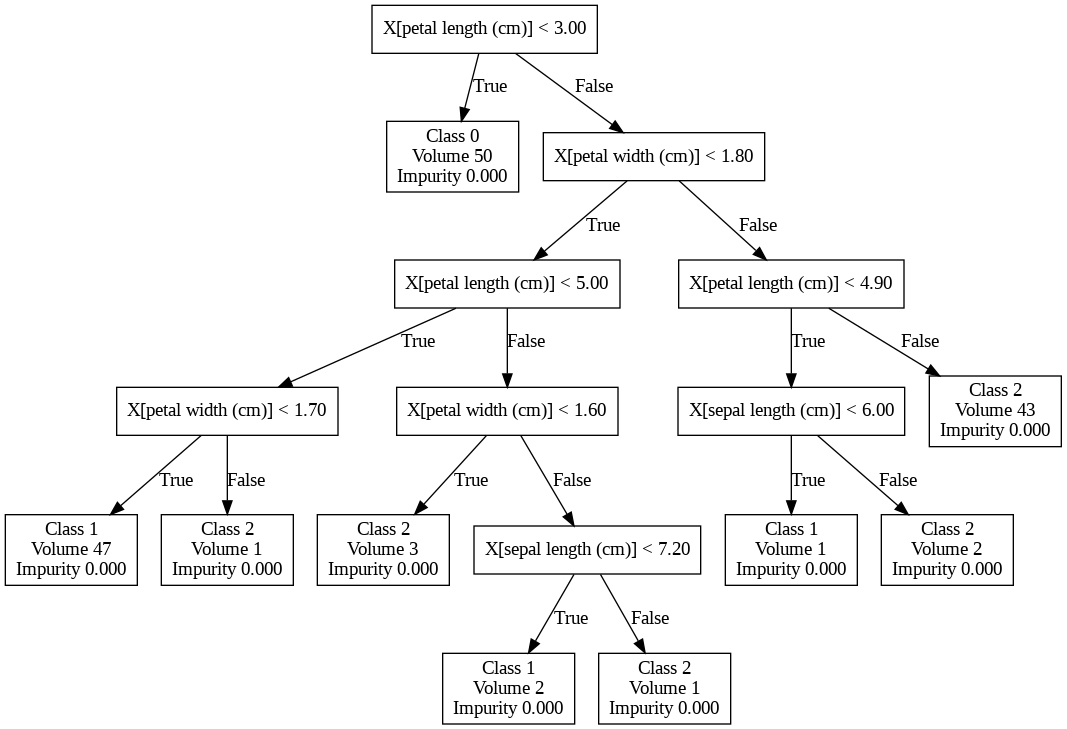

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split  # при оценке вашего алгоритма не забудьте разбить данные на тренировочную и тестовую выборки
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier  # можете сравнить качество вашего алгоритма с реализацией "из коробки"

iris = datasets.load_iris()
X = iris['data']
feature_names = iris['feature_names']
y = iris['target']
target_names = iris['target_names']

In [ ]:
# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели (с критерием Джини)
tree_gini = DecisionTree(max_depth=7, criterion='gini')
tree_gini.fit(X_train, y_train)

# Создание и обучение модели (с критерием энтропии)
tree_entropy = DecisionTree(max_depth=7, criterion='entropy')
tree_entropy.fit(X_train, y_train)

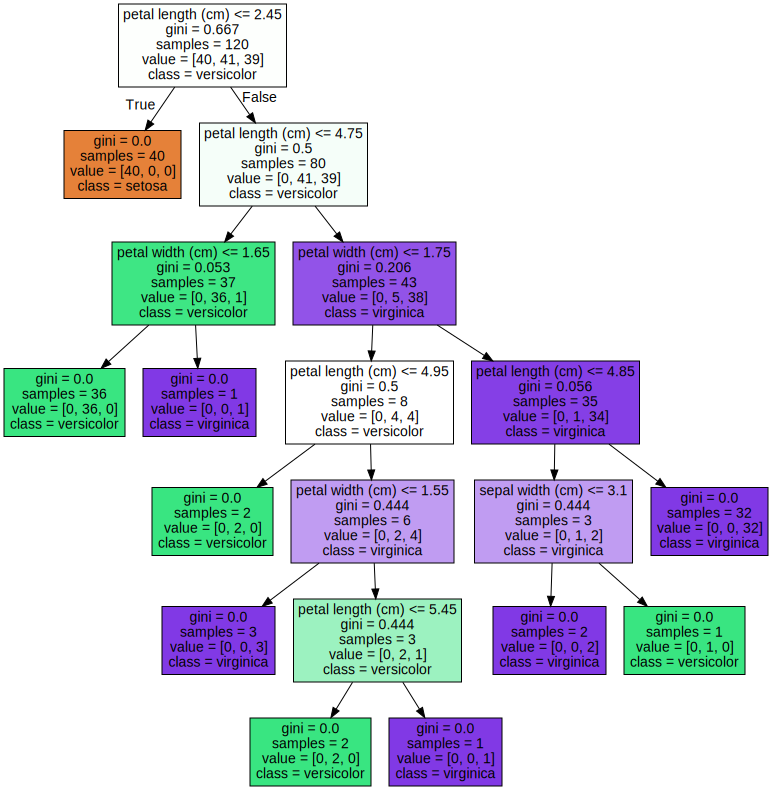

In [ ]:
# Визуализация дерева с критерием Джини
from sklearn.tree import DecisionTreeClassifier, export_graphviz
sk_tree = DecisionTreeClassifier(max_depth=7, criterion='gini', random_state=42)
sk_tree.fit(X_train, y_train)

dot_data = export_graphviz(sk_tree, out_file=None,
                         feature_names=feature_names,
                         class_names=target_names,
                         filled=True)
Source(dot_data)

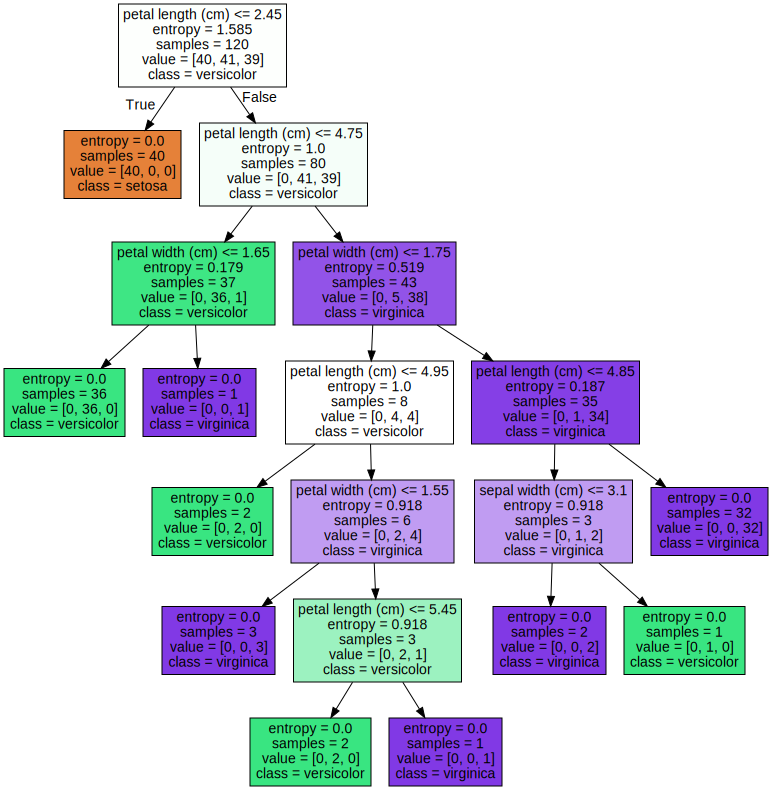

In [ ]:
# Визуализация дерева с критерием Энтропии
from sklearn.tree import DecisionTreeClassifier, export_graphviz
sk_tree = DecisionTreeClassifier(max_depth=7, criterion='entropy', random_state=42)
sk_tree.fit(X_train, y_train)

dot_data = export_graphviz(sk_tree, out_file=None,
                         feature_names=feature_names,
                         class_names=target_names,
                         filled=True)
Source(dot_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

criteria = [
    ("Max depth = 5", DecisionTree(max_depth=5)),
    ("Min samples leaf = 5", DecisionTree(min_samples_leaf=5)),
    ("Max leaves = 5", DecisionTree(max_leaves=5)),
    ("Purity threshold = 1.0", DecisionTree(purity_threshold=1.0)),
]

print("Custom Tree Classifier Results:")
for name, tree in criteria:
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy:.3f}")
    print(classification_report(y_test, y_pred, target_names=target_names))

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print("\nSklearn DecisionTreeClassifier Result:")
print(f"Accuracy: {accuracy_sklearn:.3f}")
print(classification_report(y_test, y_pred_sklearn, target_names=target_names))

TypeError: DecisionTree.__init__() got an unexpected keyword argument 'min_samples_leaf'

In [ ]:
# Создаем и обучаем модель с решением из коробки
sk_tree = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=42)
sk_tree.fit(X_train, y_train)

# Предсказания и метрики
y_pred_sk = sk_tree.predict(X_test)
print("\n=== sklearn DecisionTree (Gini) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_sk))
print("F1-score (macro):", f1_score(y_test, y_pred_sk, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sk, target_names=target_names))


=== sklearn DecisionTree (Gini) ===
Accuracy: 1.0
F1-score (macro): 1.0

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



#  [Ансамбли](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)




Суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обобщающей способности или надёжности ансамбля перед одиночным стандартным методом машинного обучения.

Можно выделить следующие типы ансамблирования:

* Бэггинг. Однотипная модель строится по различным подвыборкам обучающих данных, затем результаты аггрегируются, например, с помощью усреднения. Для деревьев решений очень распространенным алгоритмом, использующим идею бэггинга, является случайный лес.

* Бустинг. Строится последовательность однотипных моделей, где каждая следующая призвана исправлять ошибки предыдущих. Самым распространенным алгоритмом бустинга является градиентный бустинг.

* Стэкинг. Строится несколько моделей разного типа, а также мета-модель, делающая итоговое предсказание на основании предсказаний моделей.

Для последующих заданий в качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Обратите внимание, что данные нуждаются в небольшой предобаботке, так как деревья работают только с числовыми признаками.


**Загрузка данных**

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid') # установить стиль whitegrid, другие стили можно найти в документации к seaborn

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
    "mathchi/churn-for-bank-customers",
    "churn.csv",
)

Download already complete (684858 bytes).


In [ ]:
training_data = pd.read_csv('churn.csv')

In [ ]:
training_data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8416,8417,15751771,Lowe,528,Germany,Male,32,2,99092.45,1,0,1,111149.98,0
3729,3730,15697702,Lord,730,Spain,Male,29,2,0.00,2,1,0,14174.09,0
9078,9079,15705448,Gilbert,647,Germany,Male,52,7,130013.12,1,1,1,190806.36,1
7725,7726,15631756,Tuan,482,France,Female,35,5,147813.05,2,0,0,109029.72,0
792,793,15707473,Summers,850,Germany,Female,48,6,111962.99,1,1,0,111755.80,0
9698,9699,15771477,Fiorentini,779,France,Male,49,9,106160.37,1,0,0,116893.87,0
9950,9951,15638494,Salinas,625,Germany,Female,39,10,129845.26,1,1,1,96444.88,0
8683,8684,15599329,Christopher,697,France,Female,49,7,195238.29,4,0,1,131083.56,1
3364,3365,15763544,Thompson,673,France,Male,47,1,0.00,2,0,0,108762.16,0
969,970,15605926,Sinclair,649,Germany,Male,70,9,116854.71,2,0,1,107125.79,0


In [ ]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Обработка данных перед обучением**

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
training_data = training_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
training_data = pd.get_dummies(training_data, columns=['Geography', 'Gender'], dtype='int')

### Задание 2.1 (2 балла)

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи бэггинга:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализуйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества и другие. Выберите метрику, по которой вы будете сравнивать качество алгоритмов и кратко обоснуйте, почему вы выбрали именно её (в письменном формате).

Нельзя использовать готовую реализацию случайного леса из `sklearn`, но можно сопоставлять с ней качество вашего алгоритма.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from scipy.stats import mode

class RandomForest:
    def __init__(self, n_estimators=50, max_depth=5, min_samples_leaf=5, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape[0], X.shape[1]
        k = int(np.sqrt(n_features))
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X.iloc[indices]
            y_sample = y.iloc[indices]
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=k,
                random_state=self.random_state
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        y_pred, _ = mode(tree_preds, axis=0)
        return y_pred

In [ ]:
target_variable_name = 'Exited'

In [ ]:
training_data[target_variable_name].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
X = training_data.drop(target_variable_name, axis=1)
y = training_data[target_variable_name]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': np.arange(50, 151, 50),
    'max_depth': np.arange(10, 21, 5),
    'min_samples_leaf': np.arange(4, 7),
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_test, y_test)
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}


In [ ]:
rf0 = RandomForest(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
rf0.fit(X_train, y_train)
y_pred0 = rf0.predict(X_test)
f1_rf0 = f1_score(y_test, y_pred0, pos_label=1, average='binary')
print("F1-score для моего алгоритма: {:.2%}".format(f1_rf0))

F1-score для моего алгоритма: 55.54%


In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred, pos_label=1, average='binary')
print("F1-score для алгоритма из коробки: {:.2%}".format(f1_rf))

F1-score для алгоритма из коробки: 57.81%


In [ ]:
# PUT YOUR CODE HERE

## Задание 2.2 (2 балла)

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента. Можно, например, использовать [SHAP](https://habr.com/ru/companies/wunderfund/articles/739744/) для анализа. Также основные способы для определения важности признаков моделей "из коробки" [описаны здесь](https://machinelearningmastery.com/calculate-feature-importance-with-python/).

In [ ]:
# PUT YOUR CODE HERE

## Задание 3.1 (3 балла)

Вам необходимо будет реализовать алгоритм градиентного бустинга. В общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Для работы алгоритма помимо данных нужны:
1. количество итераций $M \in \mathbb{N}$;
2. функция потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (или просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой делается бустинг - будем использовать деревья решений;
4. начальное приближение $f_0(x)$ - чаще всего используют некую константу.

**Алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно для $t$ от 1 до $M$:
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Находим оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$
    4. Обновляем текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
    5. Собираем все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$
    
    
  Коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице. Однако подбор коэффициентов позволит получить более точные значения, хотя и дополнительно нагрузит алгоритм с вычислительной точки зрения. Коэффициенты выбираются из какого-либо подмножества значений от -1 до 1.

**Функции потерь:**
- $L(y, f) = \frac{1}{2}(y - f)^2$ - _MSE-loss_. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - _MAE-loss_. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать.
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \largeесли\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \largeесли\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - $L_q$-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.


Реализуйте предложенные функции потерь и их градиенты. В случае, если в вашей выборке не один объект, не забывайте нормировать значения функции потерь.


In [ ]:
def mse(y_real, y_predicted):
    pass

def mse_gradient(y_real, y_predicted):
    pass

def mae(y_real, y_predicted):
    pass

def mae_gradient(y_real, y_predicted):
    pass

def lq(y_real, y_predicted, q):
    pass

def lq_gradient(y_real, y_predicted, q=0.5):
    pass

In [ ]:
y_real = np.array([1, 2, 3, 4, 5])
y_predicted = np.array([1.2, 2.5, 2.8, 3.9, 5.1])

# Calculate metrics
mse_result = mse(y_real, y_predicted)
mae_result = mae(y_real, y_predicted)
lq_result = lq(y_real, y_predicted, q=0.8)

# Calculate gradients
mse_grad = mse_gradient(y_real, y_predicted)
mae_grad = mae_gradient(y_real, y_predicted)
lq_grad = lq_gradient(y_real, y_predicted, q=0.8)

# Tests
assert np.isclose(mse_result, 0.07)
assert np.isclose(mae_result, 0.21, rtol=1e5)
assert np.isclose(lq_result, 0.08, rtol=1e5)
assert np.allclose(mse_grad, np.array([0.4, 1, -0.4, -0.2, 0.2]))
assert np.allclose(mae_grad, np.array([1, 1, -1, -1, 1]))
assert np.allclose(lq_grad, np.array([0.8, 0.8, -0.2, -0.2, 0.8]))

print("Tests passed successfully!")

Tests passed successfully!


Реализуйте алгоритм градиентного бустинга со следующими параметрами:

* список, в котором вы будете хранить обученные деревья;
* параметры конструктора для деревьев (tree_kwargs);
* функция потерь;
* градиент функции потерь;
* bool параметр, означающий, является ли $\rho_i$ константой (единицей).

И методами:
* `fit` - в рамках этого метода вам необходимо будет строить деревья. Не забывайте передавать tree_kwargs;
* `predict` - этот метод должен последовательно применить обученные деревья для получения итогового ответа.

В качестве базового алгоритма используйте DecisionTreeRegressor из sklearn. Обычно для градиентного бустинга используют так называемые "пеньки" - деревья небольшой глубины. Это связано с тем, что алгоритм должен иметь высокую обобщающую способность и не переобучаться.


In [ ]:
from sklearn.tree import DecisionTreeRegressor


losses = {
    'MSE': (mse, mse_gradient),
    'MAE': (mae, mae_gradient),
    'lq': (lq, lq_gradient),
}


class GradientTreeBoosting:
    pass

## Задание 3.2 (2 балла)

Проверим на игрушечном примере, что алгоритм работает. Если ваша реализация отличается от используемой в примере - поправьте код примера. Но результат должен получаться похожим.

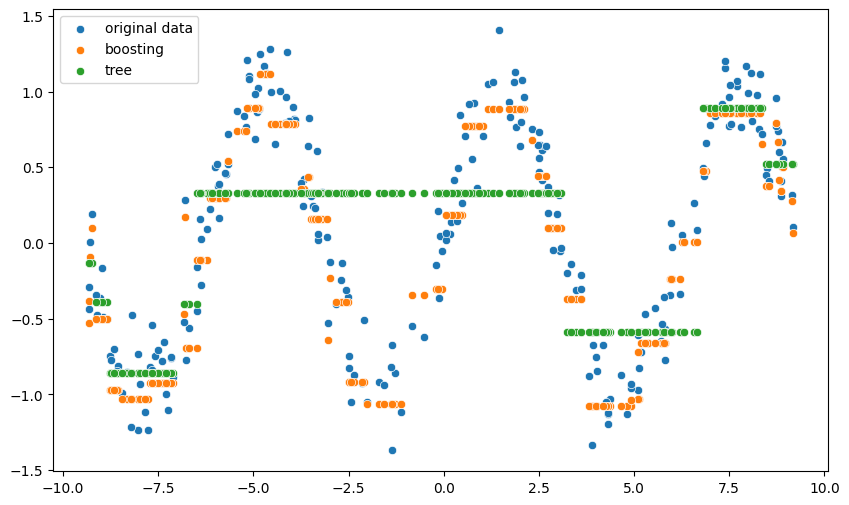

In [ ]:
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=(250))
y = np.sin(x) + np.random.randn(250) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем бустинг-ансамбль
clf = GradientTreeBoosting(loss='MSE', iterations=10, const_p=False,
                           max_depth=3, random_state=42)
clf.fit(x.reshape(-1, 1), y)

# смотрим, что вышло|
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')
plt.show()

Примените алгоритм к тем же данным, с которыми работали в предыдущем задании. Предсказывать будем не класс (0/1), а логиты, то есть вероятность того, что клиент уйдёт, и на основе неё уже делать прогноз, определяя класс относительно некого порога (по умолчанию 0.5).

In [ ]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res


Сравните вашу реализацию градиентного бустинга (с константным $\rho$ и нет) с одиночным DecisionTreeRegressor по качеству и времени выполнения. При неконстантном $\rho$ качество должно возрасти.

In [ ]:
%%time

# PUT YOUR CODE HERE